In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Jan 31 09:49:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:09:00.0 Off |                  N/A |
| 60%   64C    P2             256W / 330W |   7060MiB / 24576MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_dual_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/home/save/lse/train_dalle/train01.31-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/home/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

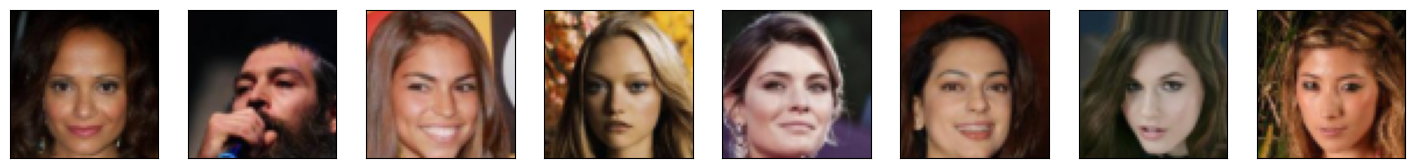

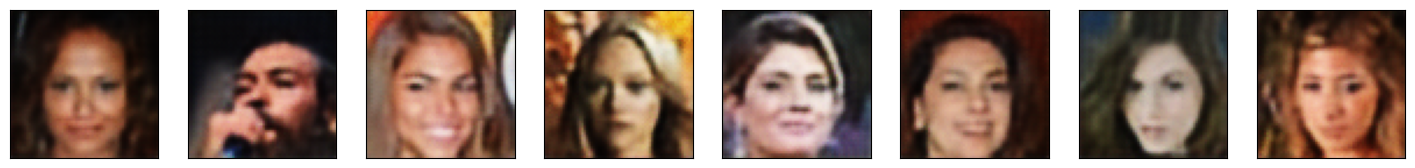

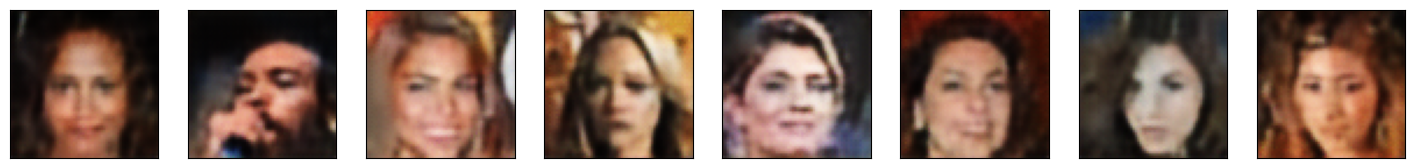

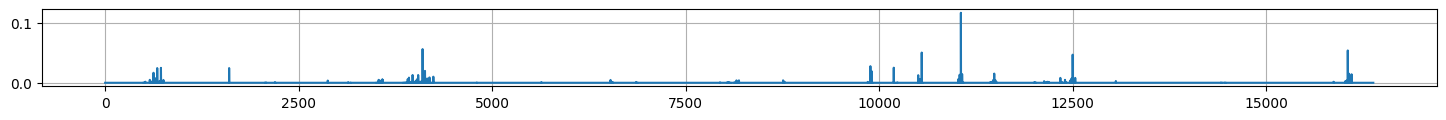

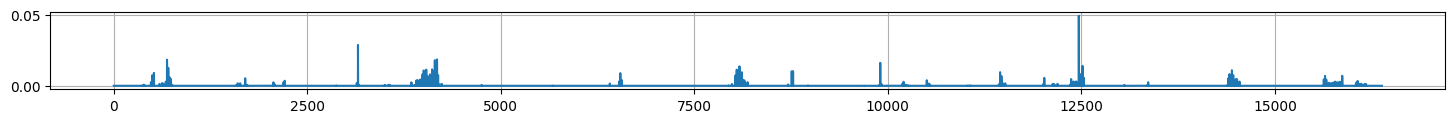

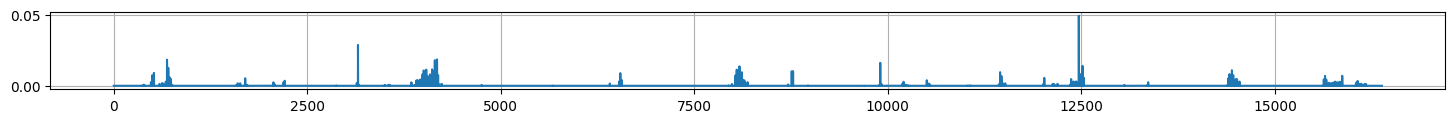

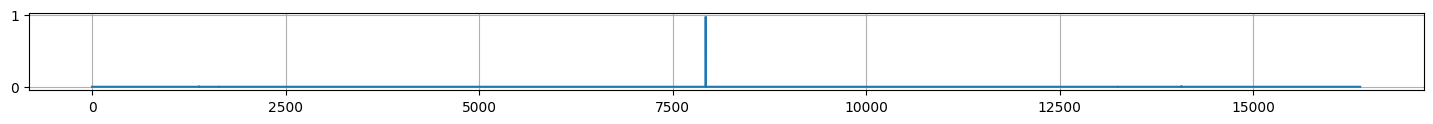

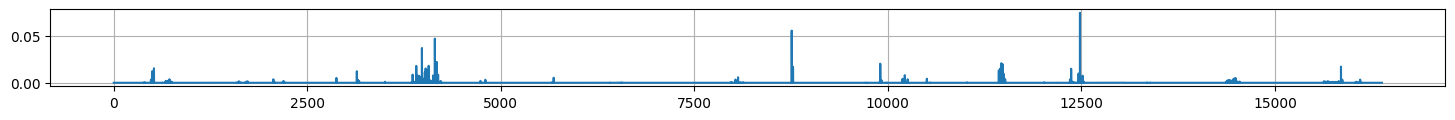

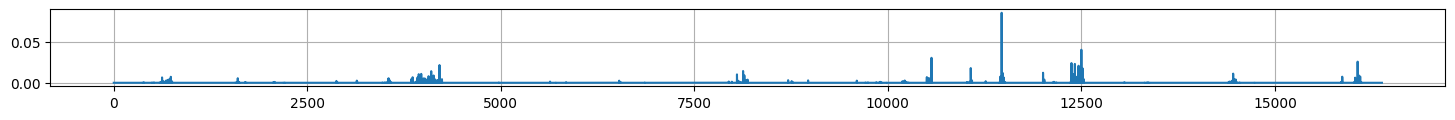

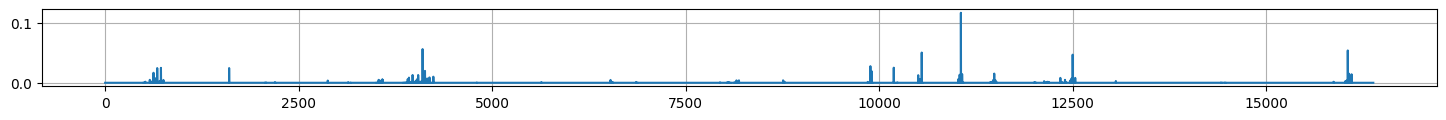

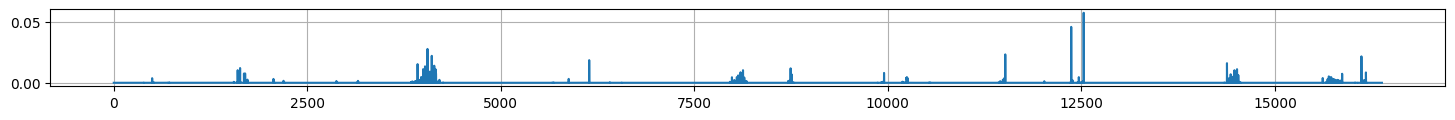

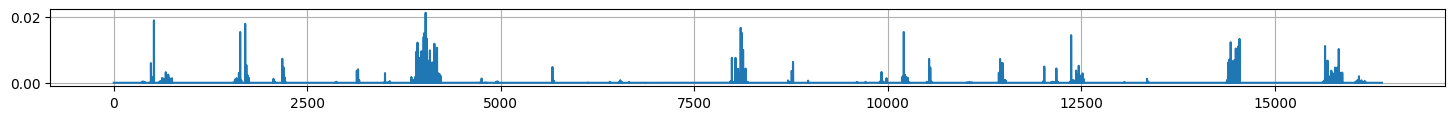

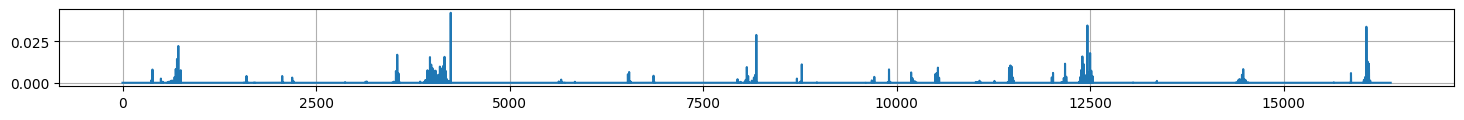

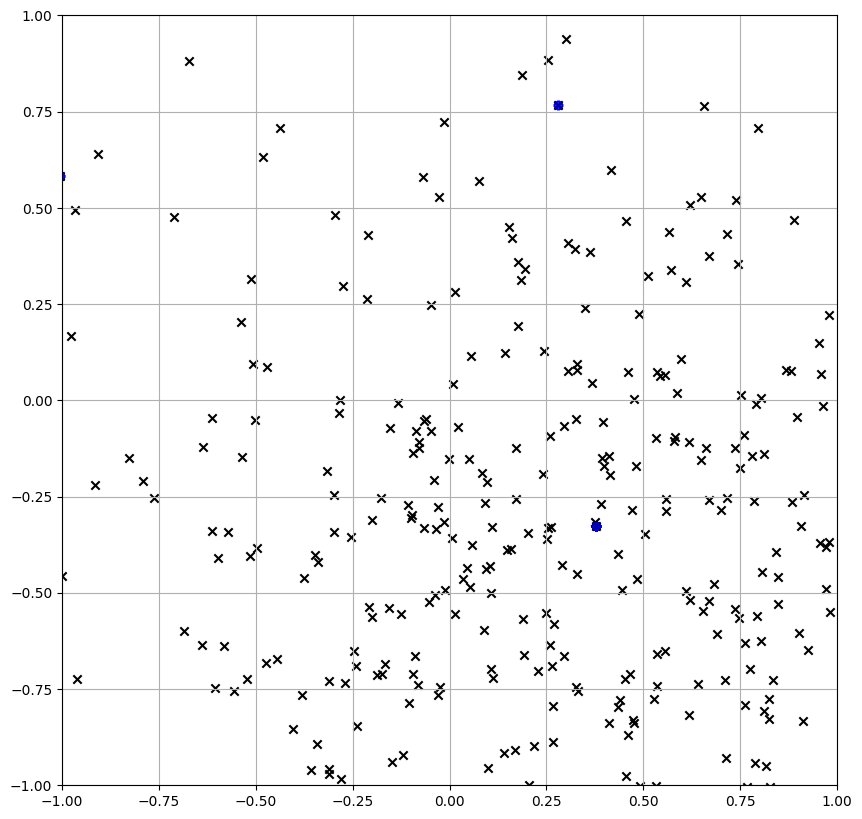

4001
lse_loss -34.14564895629883
commit_loss 0.19233039021492004
ye_recon_loss 0.001936278655193746
yq_recon_loss 0.00316726416349411
recon_loss 0.002551771467551589
4002
lse_loss -33.804527282714844
commit_loss 0.19540667533874512
ye_recon_loss 0.0021222468931227922
yq_recon_loss 0.0035719042643904686
recon_loss 0.0028470754623413086
4003
lse_loss -34.03489685058594
commit_loss 0.1955338716506958
ye_recon_loss 0.0020307120867073536
yq_recon_loss 0.0033532266970723867
recon_loss 0.0026919692754745483
4004
lse_loss -33.986419677734375
commit_loss 0.19308911263942719
ye_recon_loss 0.0019358129939064384
yq_recon_loss 0.0032286520581692457
recon_loss 0.002582232467830181
4005
lse_loss -33.92878341674805
commit_loss 0.19409270584583282
ye_recon_loss 0.0020788689143955708
yq_recon_loss 0.003436462488025427
recon_loss 0.002757665701210499
4006
lse_loss -34.2523307800293
commit_loss 0.19264408946037292
ye_recon_loss 0.002138078212738037
yq_recon_loss 0.0033691811840981245
recon_loss 0.00275362

661568
lse_loss -384.11181640625
commit_loss 0.0001721283479128033
recon_loss 0.0007455634768120944
661569
lse_loss -395.2323303222656
commit_loss 0.00015025190077722073
recon_loss 0.0008267894154414535
661570
lse_loss -395.0058288574219
commit_loss 0.00014092146011535078
recon_loss 0.0007994569605216384
661571
lse_loss -388.7666015625
commit_loss 0.00016412202967330813
recon_loss 0.0008163710008375347
661572
lse_loss -392.2781982421875
commit_loss 0.00014683674089610577
recon_loss 0.0006689074216410518
661573
lse_loss -392.81475830078125
commit_loss 0.00015679009084124118
recon_loss 0.0008143378654494882
661574
lse_loss -396.5359191894531
commit_loss 0.00016241254343185574
recon_loss 0.0008314518490806222
661575
lse_loss -389.9932861328125
commit_loss 0.00014375036698766053
recon_loss 0.000877699232660234
661576
lse_loss -386.1161804199219
commit_loss 0.00014026639109943062
recon_loss 0.0007388269295915961
661577
lse_loss -387.00579833984375
commit_loss 0.0001559286320116371
recon_los

661648
lse_loss -401.4542541503906
commit_loss 0.00014138652477413416
recon_loss 0.0008655681158415973
661649
lse_loss -401.1988220214844
commit_loss 0.0001481272338423878
recon_loss 0.0009979847818613052
661650
lse_loss -397.6663513183594
commit_loss 0.00015544146299362183
recon_loss 0.0008502835407853127
661651
lse_loss -398.4194641113281
commit_loss 0.00014928629389032722
recon_loss 0.0007527237758040428
661652
lse_loss -397.1571960449219
commit_loss 0.00015261983207892627
recon_loss 0.0008742191712372005
661653
lse_loss -396.6246643066406
commit_loss 0.00015742013056296855
recon_loss 0.0008444531704299152
661654
lse_loss -400.6316223144531
commit_loss 0.0001554326736368239
recon_loss 0.0008664058404974639
661655
lse_loss -399.7090148925781
commit_loss 0.00014816984185017645
recon_loss 0.0008309173863381147
661656
lse_loss -401.4886779785156
commit_loss 0.00015761455870233476
recon_loss 0.000788747682236135
661657
lse_loss -399.2239685058594
commit_loss 0.00015005809837020934
recon_

661729
lse_loss -389.9501647949219
commit_loss 0.00013564596883952618
recon_loss 0.000808294746093452
661730
lse_loss -396.4827880859375
commit_loss 0.0001346019998891279
recon_loss 0.0007140146335586905
661731
lse_loss -396.01324462890625
commit_loss 0.00015046788030304015
recon_loss 0.0007419682806357741
661732
lse_loss -401.1633605957031
commit_loss 0.00015469548816327006
recon_loss 0.0006574096041731536
661733
lse_loss -400.0932922363281
commit_loss 0.00015255616744980216
recon_loss 0.0006421823054552078
661734
lse_loss -392.3662109375
commit_loss 0.00015041933511383832
recon_loss 0.0007812371477484703
661735
lse_loss -395.11053466796875
commit_loss 0.0001611488696653396
recon_loss 0.0007622728007845581
661736
lse_loss -395.3117370605469
commit_loss 0.00013963777746539563
recon_loss 0.0007426897063851357
661737
lse_loss -394.4884033203125
commit_loss 0.00014617739361710846
recon_loss 0.0007375708664767444
661738
lse_loss -388.19842529296875
commit_loss 0.00014110728807281703
recon_

661811
lse_loss -399.4635925292969
commit_loss 0.0001535597548354417
recon_loss 0.0008051834302023053
661812
lse_loss -396.856689453125
commit_loss 0.00015453642117790878
recon_loss 0.0008097023237496614
661813
lse_loss -397.50274658203125
commit_loss 0.00014533083594869822
recon_loss 0.0008594535756856203
661814
lse_loss -397.534912109375
commit_loss 0.0001574150228407234
recon_loss 0.0007490323623642325
661815
lse_loss -383.19891357421875
commit_loss 0.00014844004181213677
recon_loss 0.0008680074824951589
661816
lse_loss -386.0637512207031
commit_loss 0.0001526469422969967
recon_loss 0.0007589452434331179
661817
lse_loss -395.3573303222656
commit_loss 0.0001386611838825047
recon_loss 0.0009220530628226697
661818
lse_loss -394.42816162109375
commit_loss 0.0001672593061812222
recon_loss 0.0008300069021061063
661819
lse_loss -383.9916687011719
commit_loss 0.00015847015311010182
recon_loss 0.0007068889099173248
661820
lse_loss -393.0148620605469
commit_loss 0.0001612465421203524
recon_lo

661891
lse_loss -394.7682800292969
commit_loss 0.00013129733270034194
recon_loss 0.0007917300099506974
661892
lse_loss -382.7318420410156
commit_loss 0.00015219501801766455
recon_loss 0.0007063233060762286
661893
lse_loss -389.14697265625
commit_loss 0.00014910049503669143
recon_loss 0.0007845673244446516
661894
lse_loss -390.4931945800781
commit_loss 0.00016578033682890236
recon_loss 0.0007706281030550599
661895
lse_loss -397.1249694824219
commit_loss 0.00014616454427596182
recon_loss 0.0007826220244169235
661896
lse_loss -396.4518737792969
commit_loss 0.00014028657460585237
recon_loss 0.0007298698183149099
661897
lse_loss -397.4623718261719
commit_loss 0.0001473882293794304
recon_loss 0.0008060061372816563
661898
lse_loss -400.0033874511719
commit_loss 0.00015034739044494927
recon_loss 0.0007896155584603548
661899
lse_loss -395.85028076171875
commit_loss 0.0001388902892358601
recon_loss 0.0008082295535132289
661900
lse_loss -395.28594970703125
commit_loss 0.00015337232616730034
recon

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'ye_recon_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'yq_recon_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            ye = data['ye']
            yq = data['yq']
            
            plot(x)
            plot(ye)
            plot(yq)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')